# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

# Data Loading

In [10]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/zlccr7uwq97y9cuexlilftdpmgudaz7u.npz" -O training_images_full.npz
!wget "https://sussex.box.com/shared/static/axweldiirenlc4a6xn06l6heiuawodpa.npz" -O training_images_subset.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/2ss21w2g8nd8fshhtu9r2ww2mm04xh9f.npz" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/65pyy3pjnkl5yda7ra4rvhcd89l6i7fq.npzz" -O examples.npz



zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [11]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images_full.npz', '69927c788396d4b8c05d33d1650b2aa66076c0f0')
confirm_checksum('training_images_subset.npz', '5e2690718c7b1a0d14db54f844e6e22453f5eb71')
confirm_checksum('test_images.npz', 'aed32f84664e906624c8af13b5462cbded13d539')
confirm_checksum('examples.npz', '2ea08d7b6d76b56de97325fe51daad72afaa3d73')

# Load the data

In [12]:
import numpy as np


# Load the data using np.load
data = np.load('training_images_full.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

# Load the data that only has a subset of annotations using np.load
data = np.load('training_images_subset.npz', allow_pickle=True)

# Extract the images
images_subset = data['images']
# and the data points
pts_subset = data['points']

print(images_subset.shape, pts_subset.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(1425, 256, 256, 3) (1425, 44, 2)
(1386, 256, 256, 3) (1386, 5, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

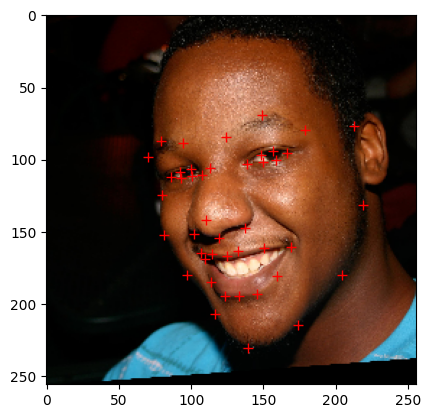

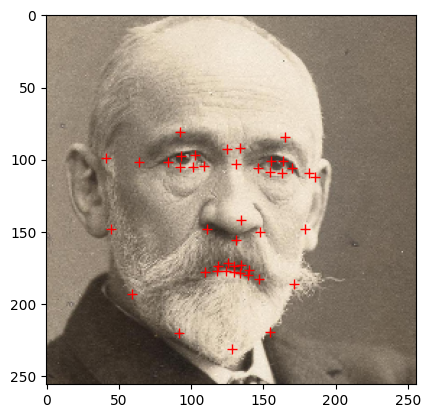

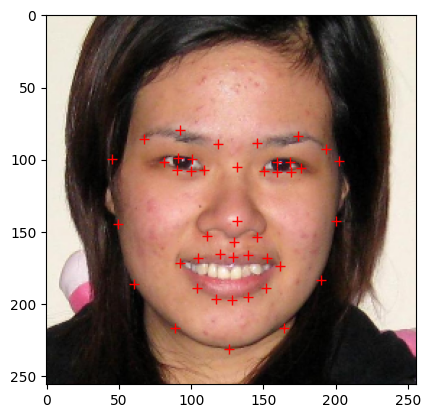

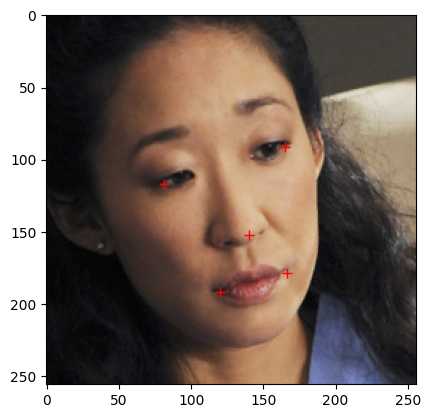

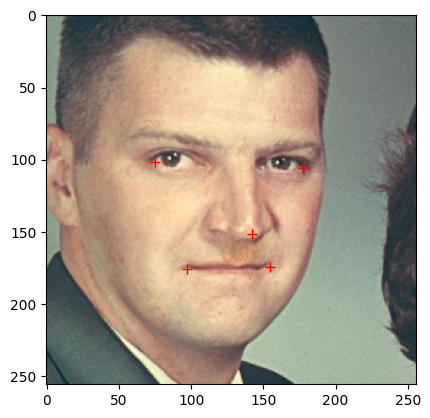

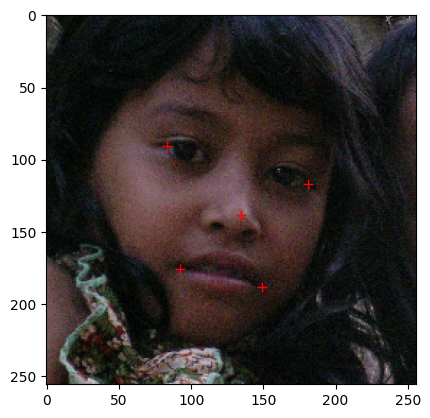

In [13]:
import matplotlib.pyplot as plt
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r', ms=7)
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images_subset[idx, ...], pts_subset[idx, ...])

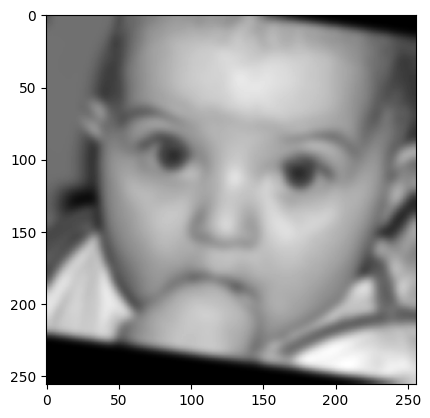

In [16]:
#Image Pre-Processing
import cv2
#Greyscale & Gaussian Blur
training_images_n = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (15,15), 3)
    training_images_n.append(blur)

plt.imshow(training_images_n[10], cmap='gray')

In [17]:
# Define the grid parameters
patch_size = 32
grid_size = 5

# Define the SIFT feature extractor
sift = cv2.SIFT_create()

# Initialize the feature matrix
feature_matrix = []

# Loop over the images
for img in training_images_n:
    # Initialize the feature vector
    feature_vector = []

    # Loop over the grid points
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate the patch coordinates
            x = i * img.shape[0] // grid_size
            y = j * img.shape[1] // grid_size
            patch = img[x:x+patch_size, y:y+patch_size]

            # Extract SIFT descriptors from the patch
            keypoints, descriptors = sift.detectAndCompute(patch, None)

            # Check if descriptors is None
            if descriptors is None:
                descriptors = np.zeros((1, 128), dtype=np.float32)

            # Append the descriptors to the feature vector
            feature_vector.extend(descriptors[:1].ravel())

    # Append the feature vector to the feature matrix
    feature_matrix.append(feature_vector)
#
# Convert the feature matrix to a numpy array
feature_matrix = np.array(feature_matrix)
print(feature_matrix)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 4.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 6. 14.  1. ...  0.  0.  0.]]


In [20]:
test_images_n = []
for img in test_images:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (15,15), 3)
    test_images_n.append(blur)

feature_matrix_test = []

for img in test_images_n:
    feature_vector = []

    for i in range(grid_size):
        for j in range(grid_size):
            x = i * img.shape[0] // grid_size
            y = j * img.shape[1] // grid_size
            patch = img[x:x+patch_size, y:y+patch_size]

            keypoints, descriptors = sift.detectAndCompute(patch, None)

            if descriptors is None:
                descriptors = np.zeros((1, 128), dtype=np.float32)

            feature_vector.extend(descriptors[:1].ravel())

    feature_matrix_test.append(feature_vector)

feature_matrix_test = np.array(feature_matrix_test)


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Initialize an empty list to hold the trained regressors
regressors = []

# Loop over the points (columns)
for col in range(pts.shape[1]):
    # Train a random forest regressor on the full dataset
    rf_full = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    rf_full.fit(feature_matrix, pts[:, col])

    # Append the trained regressors to the list
    regressors.append(rf_full)

In [23]:
predicted_points = []

for img_features in feature_matrix_test:
    img_points = []

    for col, rf_full in enumerate(regressors):
        p_full = rf_full.predict([img_features])[0]
        img_points.append(p_full)

    predicted_points.append(np.array(img_points).reshape(-1, 2))
r

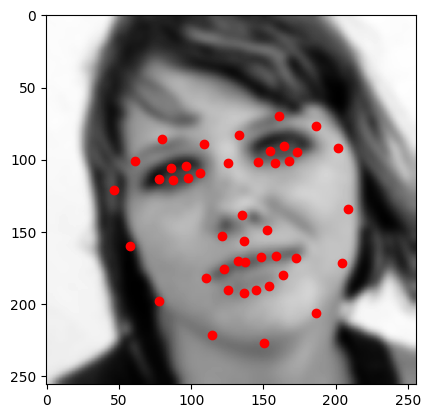

In [24]:
import matplotlib.pyplot as plt

# Example: visualize the 10th test image with its predicted points
plt.imshow(test_images_n[10], cmap='gray')
plt.scatter(predicted_points[10][:, 0], predicted_points[10][:, 1], c='r', marker='o')
plt.show()


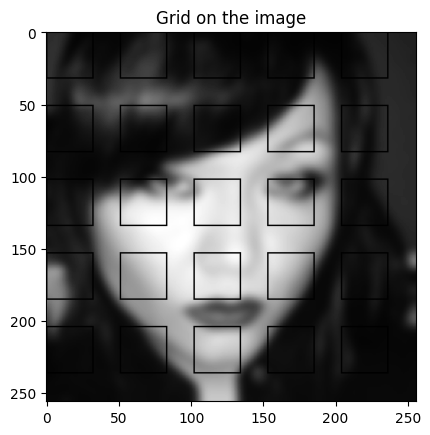

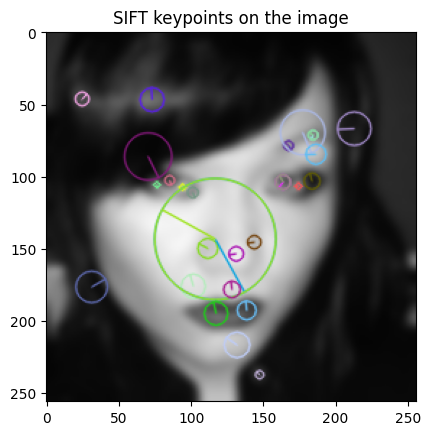

In [ ]:
def draw_grid(image, grid_size):
    grid_image = image.copy()
    for i in range(grid_size):
        for j in range(grid_size):
            x = i * image.shape[0] // grid_size
            y = j * image.shape[1] // grid_size
            cv2.rectangle(grid_image, (y, x), (y+patch_size, x+patch_size), (0, 255, 0), 1)
    return grid_image

def draw_keypoints(image, keypoints):
    keypoints_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return keypoints_image

index = 0  # Select an index of the image you want to visualize from test_images_n list
image = test_images_n[index]

# Visualize the grid on the image
grid_image = draw_grid(image, grid_size)
plt.imshow(grid_image, cmap='gray')
plt.title("Grid on the image")
plt.show()

# Visualize the keypoints and descriptors on the image
keypoints_image = draw_keypoints(image, sift.detect(image, None))
plt.imshow(keypoints_image, cmap='gray')
plt.title("SIFT keypoints on the image")
plt.show()

In [25]:
subset_images_n = []
for img in images_subset:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (15, 15), 3)
    subset_images_n.append(blur)

feature_matrix_subset = []

for img in subset_images_n:
    feature_vector = []

    for i in range(grid_size):
        for j in range(grid_size):
            x = i * img.shape[0] // grid_size
            y = j * img.shape[1] // grid_size
            patch = img[x:x+patch_size, y:y+patch_size]

            keypoints, descriptors = sift.detectAndCompute(patch, None)

            if descriptors is None:
                descriptors = np.zeros((1, 128), dtype=np.float32)

            feature_vector.extend(descriptors[:1].ravel())

    feature_matrix_subset.append(feature_vector)

feature_matrix_subset = np.array(feature_matrix_subset)


In [26]:
subset_regressors = []

for col in range(pts_subset.shape[1]):
    rf_subset = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    rf_subset.fit(feature_matrix_subset, pts_subset[:, col])
    subset_regressors.append(rf_subset)


In [27]:
predicted_points_subset = []

for img_features in feature_matrix_test:
    img_points = []

    for col, rf_subset in enumerate(subset_regressors):
        p_subset = rf_subset.predict([img_features])[0]
        img_points.append(p_subset)

    predicted_points_subset.append(np.array(img_points).reshape(-1, 2))


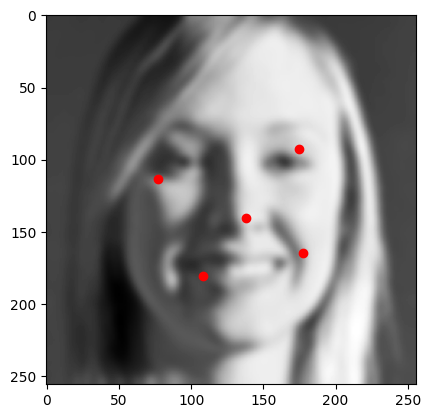

In [28]:
import matplotlib.pyplot as plt

# Example: visualize the 10th test image with its predicted points
plt.imshow(subset_images_n[10], cmap='gray')
plt.scatter(predicted_points_subset[10][:, 0], predicted_points_subset[10][:, 1], c='r', marker='o')
plt.show()


In [39]:
pts_train, pts_test = train_test_split(pts, test_size=0.25, random_state=42)

test_points_subset = extract_subset_of_points(pts_test)

# Full dataset
errors_full = euclid_dist(predicted_points, pts_test)

# Subset dataset
errors_subset = euclid_dist(predicted_points_subset, test_points_subset)

avg_error_full = np.mean(errors_full)
avg_error_subset = np.mean(errors_subset)

print(f"Average prediction error for full dataset regressors: {avg_error_full:.2f}")
print(f"Average prediction error for subset dataset regressors: {avg_error_subset:.2f}")

# Save the predicted points from the full dataset regressors
save_as_csv(predicted_points, location='path/to/save/full')

# Save the predicted points from the subset dataset regressors
save_as_csv(predicted_points_subset, location='path/to/save/subset')


NameError: name 'train_test_split' is not defined

# Extracting Subset of Points from Full Set. Calculating Prediction Error. and Exporting Results

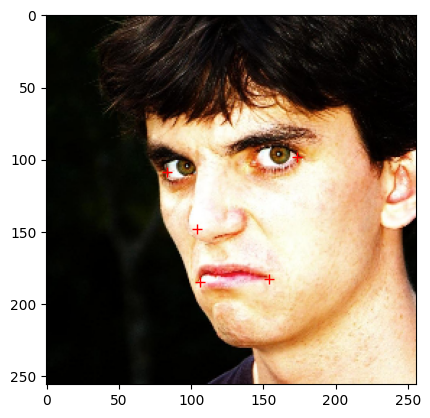

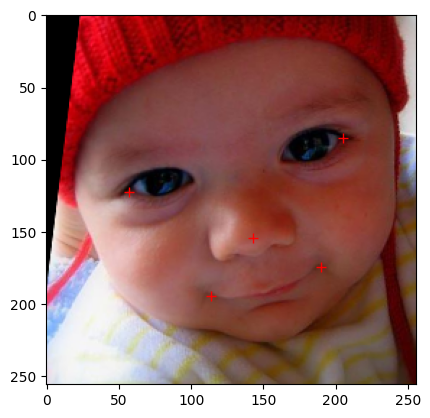

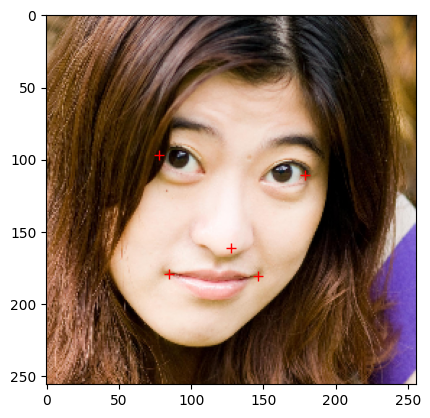

In [30]:
def extract_subset_of_points(pts):
  indices = (20, 29, 16, 32, 38)
  if len(pts.shape) == 3:
    return pts[:, indices, :]
  elif len(pts.shape) == 2:
    return pts[indices, :]


for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], extract_subset_of_points(pts[idx, ...]))


In [31]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [32]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 34 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')
